# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import math
from pfa_util import *

In [3]:
# Color style similar to ppt color scheme
plt.style.use('seaborn-colorblind')

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})

In [4]:
def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['//'], ['-'], ['x'], ['\\'], ['||'], ['+'], ['o'], ['.']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
    ax.legend()

In [7]:
# RamSwap on x86
x86_res = ingest_run('raw/results_x86.csv', 'x86')

# Paging to remote memory in SW ('baseline')
base_res = ingest_run('raw/results_baseline.csv', 'rv')

# Paging using the PFA to real memblade
pfa_res = ingest_run('raw/results_pfa.csv', 'rv')

# RamSwap on firesim
ram_res = ingest_run('raw/results_rvRamSwap.csv', 'rv')

# pfa_res['genome'].mean
pfa_res['python'].mean.keys()

Index(['t_run', 't_bookkeeping', 't_rmem_write', 't_rmem_read', 'n_fault',
       't_fault', 'n_swapfault', 'n_pfa_fault', 'n_early_newq', 'n_evicted',
       'n_fetched', 'n_kpfad', 't_kpfad', 'slowdown'],
      dtype='object')

## Quick Checks
Not actually used in the paper

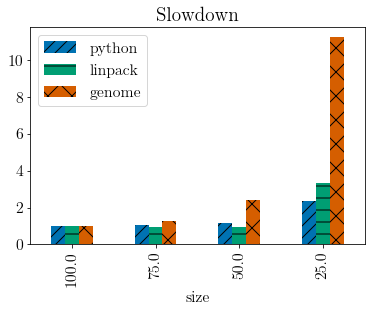

In [5]:
e2e_bench_means = [pfa_res[Bname].mean['slowdown'].rename(Bname) for Bname in pfa_res.keys()]
e2e_bench_stds = [pfa_res[Bname].std['slowdown'].rename(Bname) for Bname in pfa_res.keys()]
e2e_means = pd.concat(e2e_bench_means, axis='columns')
e2e_stds = pd.concat(e2e_bench_stds, axis='columns')

ax = e2e_means.plot.bar(title='Slowdown')

make_hatches(ax, e2e_means)
plt.show()

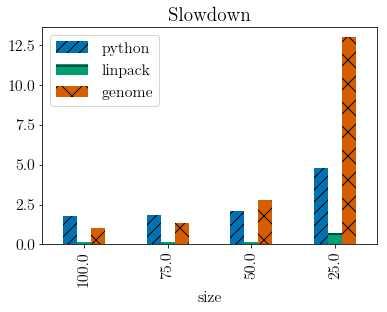

In [6]:
e2e_bench_means = [base_res[Bname].mean['t_run'].rename(Bname) for Bname in pfa_res.keys()]
e2e_bench_stds = [base_res[Bname].std['t_run'].rename(Bname) for Bname in pfa_res.keys()]
e2e_means = pd.concat(e2e_bench_means, axis='columns')
e2e_stds = pd.concat(e2e_bench_stds, axis='columns')

ax = e2e_means.plot.bar(title='Slowdown')

make_hatches(ax, e2e_means)
plt.show()

In [7]:
pfa_res['python'].mean

,t_run,t_bookkeeping,t_rmem_write,t_rmem_read,n_fault,t_fault,n_swapfault,n_pfa_fault,n_early_newq,n_evicted,n_fetched,n_kpfad,t_kpfad,slowdown
size,,,,,,,,,,,,,,
100.0,1.684221,0.005289,0.002702,0.0,10656.333333,0.079287,0.0,12.000000,92.333333,1045.333333,738.333333,0.0,0.0,1.000000
75.0,1.730389,0.031244,0.009852,0.0,17876.000000,0.105684,0.0,47.666667,333.333333,3835.000000,3049.000000,0.0,0.0,1.027412
50.0,1.952219,0.137448,0.032581,0.0,36312.666667,0.259532,0.0,177.666667,1658.666667,12691.333333,11380.000000,0.0,0.0,1.159123
25.0,3.997994,0.843604,0.179366,0.0,190521.333333,1.905531,0.0,1062.000000,7976.333333,69938.666667,67976.666667,0.0,0.0,2.373794


# Intro/Motivation

## x86 RamSwap Slowdown

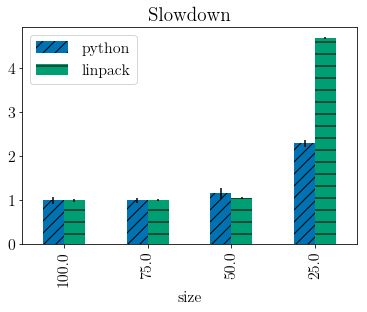

In [8]:
e2e_bench_means = [x86_res[Bname].mean['slowdown'].rename(Bname) for Bname in x86_res.keys()]
e2e_bench_stds = [x86_res[Bname].std['slowdown'].rename(Bname) for Bname in x86_res.keys()]
e2e_mean = pd.concat(e2e_bench_means, axis='columns')
e2e_std = pd.concat(e2e_bench_stds, axis='columns')

ax = e2e_mean.plot.bar(title='Slowdown', yerr=e2e_bench_stds)
make_hatches(ax, e2e_means)
plt.show()

            25.0      50.0      75.0      100.0
python   0.076848  0.122047  0.050893  0.074702
linpack  0.014919  0.023826  0.030363  0.039672


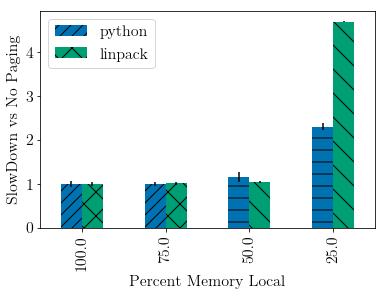

In [9]:
total_slowdown_mean = pd.DataFrame()
total_slowdown_std = pd.DataFrame()
for Bname,Bf in x86_res.items():
    total_slowdown_mean = total_slowdown_mean.append(Bf.mean['slowdown'].rename(Bname))
    total_slowdown_std = total_slowdown_std.append(Bf.std['slowdown'].rename(Bname))

print(total_slowdown_std)
total_slowdown_mean.sort_index(axis=1, inplace=True, ascending=False)
ax = total_slowdown_mean.T.plot(
    yerr=total_slowdown_std.T,
    kind='bar',
    linewidth=3)

make_hatches(ax, total_slowdown_mean)

plt.ylabel('SlowDown vs No Paging')
plt.xlabel('Percent Memory Local')
plt.savefig('figs/paging_overhead.png', dpi=300, bbox_inches='tight')
plt.show()

## PFLat

In [10]:
pflat = ingest_pflat('raw/pflat.csv')

### x86 Page Fault

In [11]:
stat = pflat['x86'] * 1E9
print("End-to-End: " + "{0:.2f}".format(stat.loc['e2e', 'mean']) + "±" + "{0:.2f}".format(stat.loc['e2e','std']) +
      " [" + "{0:.2f}".format(stat.loc['e2e', 'min']) + " - " + "{0:.2f}".format(stat.loc['e2e', 'max']) + "]")
print("Trap: " + "{0:.2f}".format(stat.loc['trap', 'mean']) + "±" + "{0:.2f}".format(stat.loc['trap','std']) +
      " [" + "{0:.2f}".format(stat.loc['trap', 'min']) + " - " + "{0:.2f}".format(stat.loc['trap', 'max']) + "]")

End-to-End: 7938.57±3418.70 [4530.07 - 13169.28]
Trap: 866.62±26.39 [831.85 - 908.94]


### Rocket Page Fault:

In [12]:
stat = pflat['rvRamSwap'] * 1E9
print("End-to-End: " + 
      "{0:.2f}".format(stat.loc['e2e', 'mean']) + "±" + "{0:.2f}".format(stat.loc['e2e','std']) +
      " [" + "{0:.2f}".format(stat.loc['e2e', 'min']) + " - " + "{0:.2f}".format(stat.loc['e2e', 'max']) + "]")
print("Trap: " + "{0:.2f}".format(stat.loc['trap', 'mean']) + "±" + "{0:.2f}".format(stat.loc['trap','std']) +
      " [" + "{0:.2f}".format(stat.loc['trap', 'min']) + " - " + "{0:.2f}".format(stat.loc['trap', 'max']) + "]")

End-to-End: 6416.19±173.76 [6082.50 - 6711.25]
Trap: 137.84±13.28 [115.31 - 164.06]


## Micro-Benchmarks and Measurements

In [13]:
micro = ingest_micro("raw/micro_new.csv")

### Mean (us):

In [14]:
micro.mean * 1E6

,PFA,rvSW,rvRamSwap,x86RamSwap
measurement,,,,
t_miss,2.460906,5.314031,6.416187,7.938570
t_read_memblade_measured,NaN,2.685125,3.136219,0.842912
t_trap,0.014063,0.119938,0.137844,0.866619


### Standard Deviation (us):

In [15]:
micro.std * 1E6

,PFA,rvSW,rvRamSwap,x86RamSwap
measurement,,,,
t_miss,0.021082,0.099988,0.173761,3.418700
t_read_memblade_measured,NaN,0.013845,0.011609,0.037618
t_trap,0.000000,0.015123,0.013284,0.026394


# Facts and Figures

## Fault Timing Breakdown

In [16]:
def breakdown_fault(df):
    tmp = df.transpose().fillna(0)
    ft = pd.DataFrame(index=tmp.index.copy())
    ft['Trap'] = tmp['t_trap']
    ft['Proc'] = tmp['t_fetch'] - tmp['t_trap']
    # This is measured directly in VCS
    ft['Proc']['PFA'] = 1 / 3.2
    ft['NIC'] = tmp['t_read_memblade_measured'] - tmp['t_read_switch_memblade_theory']
    ft['NIC']['PFA'] = tmp['t_miss']['PFA'] - ft['Trap']['PFA'] - ft['Proc']['PFA'] - tmp['t_read_switch_memblade_theory']['PFA']
    ft['MemBlade'] = tmp['t_read_switch_memblade_theory']
    #This is an optimistic memory blade (~1us)
    #ft['MemBlade'] = 1129
    return ft
    

#pfa_fetchtime_mean = breakdown_fault(micro_mean)
#pfa_fetchtime_std  = breakdown_fault(micro_std)
#pfa_fetchtime_std['MemBlade'] = 0

#print(pfa_fetchtime_mean.sum(axis=1)['SW'] / pfa_fetchtime_mean.sum(axis=1)['PFA'])
#ax = pfa_fetchtime_mean.plot(kind='bar', stacked=True, yerr=pfa_fetchtime_std, legend=False)
#ax = pfa_fetchtime_mean.plot(kind='bar', stacked=True, legend=False)
#hatches = ['o', 'o', 'x', 'x', '//', '//','|','|']
#for i,bar in enumerate(ax.patches):
#    bar.set_hatch(hatches[i])

#ax.legend()
#ax.set_ylabel('Time (ns)')
#plt.savefig('figs/fetch_breakdown.png', dpi=300, bbox_inches='tight')
#plt.show()

## Page Faults

### ??

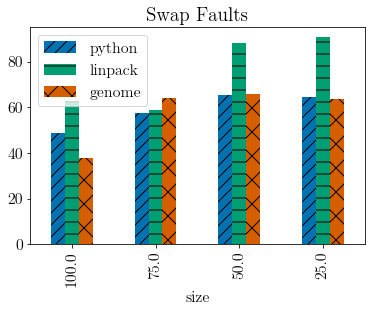

,python,linpack,genome
size,,,
100.0,48.638889,63.000000,38.000000
75.0,57.349650,58.666667,64.176425
50.0,65.380863,88.000000,65.781001
25.0,64.504080,90.690778,63.656595


In [17]:
swap_pf_bench = [(base_res[Bname].mean['n_swapfault'] / pfa_res[Bname].mean['n_pfa_fault']).rename(Bname)
                 for Bname in base_res.keys()]
swap_pf = pd.concat(swap_pf_bench, axis='columns')

ax = swap_pf.plot.bar(title='Swap Faults')
make_hatches(ax, swap_pf)
plt.show()
swap_pf

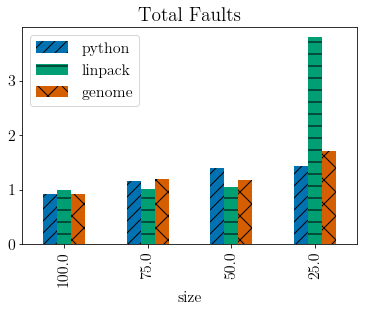

In [18]:
total_pf_bench = [(base_res[Bname].mean['n_fault'] / pfa_res[Bname].mean['n_fault']).rename(Bname)
                 for Bname in base_res.keys()]
total_pf = pd.concat(total_pf_bench, axis='columns')


ax = total_pf.plot.bar(title='Total Faults')
make_hatches(ax, total_pf)
plt.show()

24


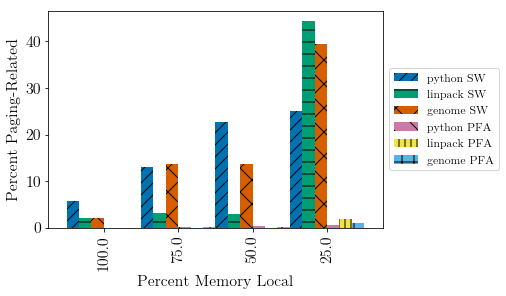

,python SW,linpack SW,genome SW,python PFA,linpack PFA,genome PFA
size,,,,,,
100.0,0.058774,0.022520,0.021234,0.001126,0.000354,0.000516
75.0,0.131178,0.032164,0.136658,0.002667,0.000561,0.002562
50.0,0.227878,0.029422,0.136446,0.004893,0.000354,0.002448
25.0,0.250020,0.444045,0.395334,0.005574,0.018586,0.010642


In [19]:
swap_fault_bench = [(base_res[Bname].mean['n_swapfault'] / base_res[Bname].mean['n_fault']).rename(Bname + " SW")
                 for Bname in base_res.keys()]
swap_fault_bench += [(pfa_res[Bname].mean['n_pfa_fault'] / pfa_res[Bname].mean['n_fault']).rename(Bname + " PFA")
                 for Bname in base_res.keys()]
swap_fault = pd.concat(swap_fault_bench, axis='columns')

ax = (swap_fault * 100).plot(kind='bar', legend=False, align='center', width=1)
print(len(ax.patches))
make_hatches(ax, swap_fault)

ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Percent Paging-Related')
ax.set_xlabel('Percent Memory Local')
plt.savefig('figs/swapfault.png', dpi=300, bbox_inches='tight')
plt.show()
swap_fault

## Bookkeeping Time

### PFA Savings in bookkeeping time

In [20]:
print("Average Slowdown in Bookkeeping time (pfa / sw)")
for Bname in pfa_res.keys():
    print(Bname + ": " + str(pfa_res[Bname].mean['t_bookkeeping'].mean() / base_res[Bname].mean['t_bookkeeping'].mean()))

Average Slowdown in Bookkeeping time (pfa / sw)
python: 0.7481755356333696
linpack: 0.5617444858702855
genome: 0.7964835654031587


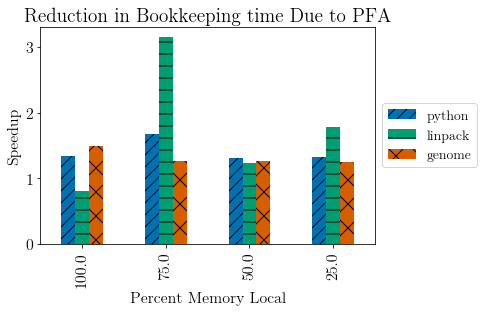

,python,linpack,genome
size,,,
100.0,1.334280,0.804638,1.489702
75.0,1.679427,3.153871,1.268191
50.0,1.306860,1.241297,1.269063
25.0,1.328745,1.780713,1.253530


In [21]:
bk_bench = [(base_res[Bname].mean['t_bookkeeping'] / pfa_res[Bname].mean['t_bookkeeping']).rename(Bname)
                 for Bname in base_res.keys()]
bk = pd.concat(bk_bench, axis='columns')

ax = bk.plot.bar(title='Reduction in Bookkeeping time Due to PFA')
make_hatches(ax, bk)
ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Speedup')
ax.set_xlabel('Percent Memory Local')

plt.show()
bk

### Time Spent In Bookkeeping

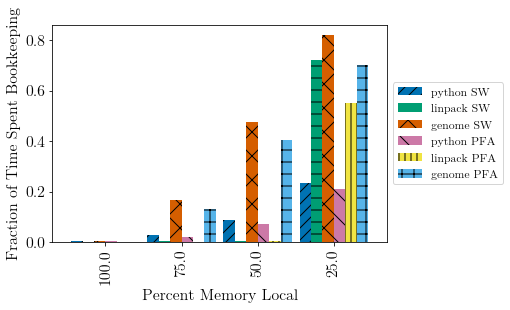

,python SW,linpack SW,genome SW,python PFA,linpack PFA,genome PFA
size,,,,,,
100.0,0.003896,0.001325,0.002457,0.003140,0.001643,0.001603
75.0,0.028191,0.005147,0.164666,0.018056,0.001631,0.131251
50.0,0.086432,0.003560,0.476781,0.070406,0.002875,0.402943
25.0,0.234282,0.719957,0.820041,0.211007,0.551604,0.702925


In [22]:
bk_bench = [(base_res[Bname].mean['t_bookkeeping'] / base_res[Bname].mean['t_run']).rename(Bname + " SW")
                 for Bname in base_res.keys()]
bk_bench += [(pfa_res[Bname].mean['t_bookkeeping'] / pfa_res[Bname].mean['t_run']).rename(Bname + " PFA")
                 for Bname in base_res.keys()]
bk = pd.concat(bk_bench, axis='columns')

ax = bk.plot(kind='bar', legend=False, align='center', width=0.9)
make_hatches(ax, bk)

ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Fraction of Time Spent Bookkeeping')
ax.set_xlabel('Percent Memory Local')
plt.savefig('figs/bk_time.png', dpi=300, bbox_inches='tight')
plt.show()
bk

## End to End Performance

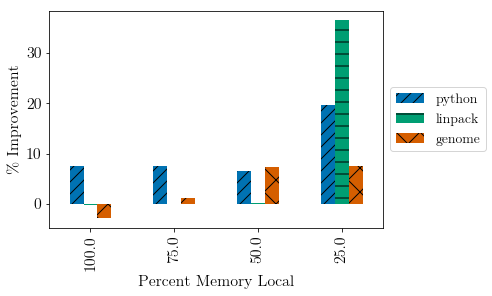

,python,linpack,genome
size,,,
100.0,7.559161,-0.281946,-2.820823
75.0,7.567655,-0.046161,1.084546
50.0,6.454340,0.244450,7.252632
25.0,19.673608,36.431587,7.450410


In [23]:
g
speedup

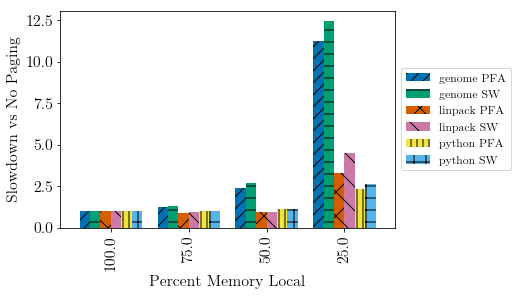

,genome PFA,genome SW,linpack PFA,linpack SW,python PFA,python SW
size,,,,,,
100.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75.0,1.245623,1.295681,0.933616,0.935823,1.027412,1.027493
50.0,2.435993,2.688505,0.958563,0.963623,1.159123,1.147217
25.0,11.260511,12.450677,3.314253,4.534473,2.373794,2.641156


In [24]:
sd_bench = [(base_res[Bname].mean['slowdown']).rename(Bname + " SW")
                 for Bname in base_res.keys()]
sd_bench += [(pfa_res[Bname].mean['slowdown']).rename(Bname + " PFA")
                 for Bname in base_res.keys()]
sd = pd.concat(sd_bench, axis='columns').sort_index(axis='columns')

ax = sd.plot(kind='bar', legend=False, align='center', width=0.8)
make_hatches(ax, sd)

ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Slowdown vs No Paging')
ax.set_xlabel('Percent Memory Local')
plt.savefig('figs/perf.png', dpi=300, bbox_inches='tight')
plt.show()
sd